# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.378003,False,-2.881999
1,-1.478723,False,-2.338082
2,2.529891,True,10.380127
3,-1.913200,False,-3.499983
4,-0.002927,False,-0.138338
...,...,...,...
995,-1.027010,False,-2.912444
996,0.143228,False,0.009067
997,-0.850186,False,-0.996546
998,-1.586306,True,1.951516


<Axes: xlabel='v0'>

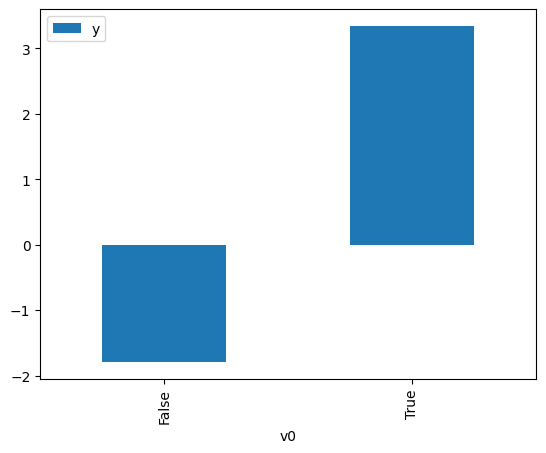

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

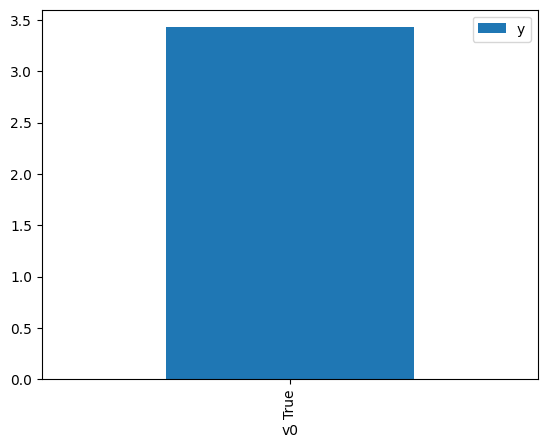

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.705527,False,1.445659,0.326316,3.064513
1,-1.141055,False,-3.516353,0.808525,1.236820
2,-1.368134,False,-2.308635,0.846412,1.181458
3,-1.101770,False,-3.284488,0.801292,1.247985
4,-1.519173,False,-4.929007,0.868052,1.152005
...,...,...,...,...,...
995,1.095534,False,2.769568,0.234652,4.261626
996,-2.058364,False,-4.822193,0.925264,1.080773
997,-1.404758,False,-3.017929,0.851912,1.173830
998,-1.259141,False,-3.188708,0.829052,1.206197


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.640128,True,4.980345,0.298793,3.346802
1,0.334131,True,5.848508,0.571846,1.748723
2,-1.059523,True,2.885762,0.206714,4.837597
3,-0.114775,True,5.647743,0.441023,2.267456
4,-0.898810,True,3.879089,0.239324,4.178441
...,...,...,...,...,...
995,-0.970227,True,2.294634,0.224412,4.456082
996,-1.383270,True,2.342083,0.151295,6.609606
997,-0.072594,True,3.928139,0.453250,2.206290
998,-1.337319,True,-0.079544,0.158345,6.315343


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.931
Model:                            OLS   Adj. R-squared (uncentered):              0.931
Method:                 Least Squares   F-statistic:                              6758.
Date:                Tue, 18 Jun 2024   Prob (F-statistic):                        0.00
Time:                        02:02:25   Log-Likelihood:                         -1418.8
No. Observations:                1000   AIC:                                      2842.
Df Residuals:                     998   BIC:                                      2851.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.0819      0.025     84.015      0.000       2.033       2.131
x2             4.9631      0.058     85.568      0.000       4.849       5.077
==============================================================================
Omnibus:                        0.509   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.775   Jarque-Bera (JB):                0.447
Skew:                           0.050   Prob(JB):                        0.800
Kurtosis:                       3.030   Cond. No.                         2.35
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""